In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode+1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        # The very first state(== observation)
        observation = env.reset()

        # Select the first action given the first state
        action = np.random.choice(env.action_space.n, p=policy(observation))

        # We are naively assuming finite lengths of episodes here.
        # Using while loop like this might lead to infinite loop
        # depending on environments. Adding measures to enforce
        # finite number of iterations might be useful.     
        episode_finished = False

        while not episode_finished:
            # Update the total number of steps in this episode (for stats purposes)
            stats.episode_lengths[i_episode] += 1
            
            # Need to backup the current state before moving on
            # to do the lookahead
            prev_observation = observation

            # Record the result of the action
            observation, reward, done, _ = env.step(action)

            # Update the total reward obtained from this episode (for stats purposes)
            stats.episode_rewards[i_episode] += reward
            
            if done:
                # If we receive 'done' signal, let's finish up the episode
                episode_finished = True

                # When we reached the terminal state, there is no more future state-actions
                Q[prev_observation][action] += alpha * (reward - Q[prev_observation][action])
                
            else:
                # Select next action in advance to do the lookahead
                next_action = np.random.choice(env.action_space.n, p=policy(observation))
                
                # The action with currently the biggest value
                greedy_next_action = np.argmax(Q[observation])

                # Note that we use Q value of greedy action to update, instead of next_action.
                Q[prev_observation][action] += alpha * (
                    reward + discount_factor * Q[observation][greedy_next_action] - Q[prev_observation][action]
                )

                # We will do the next_action at the next iteration
                action = next_action
    
    return Q, stats

In [5]:
Q, stats = q_learning(env, 500)

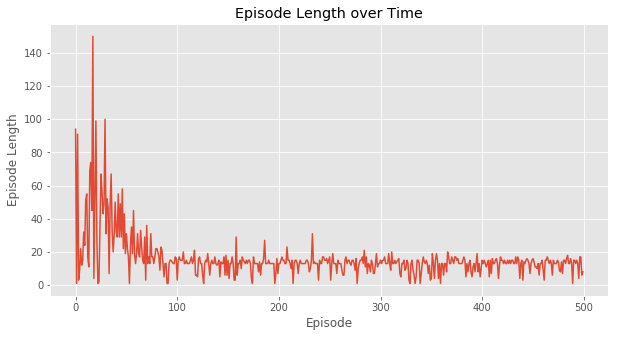

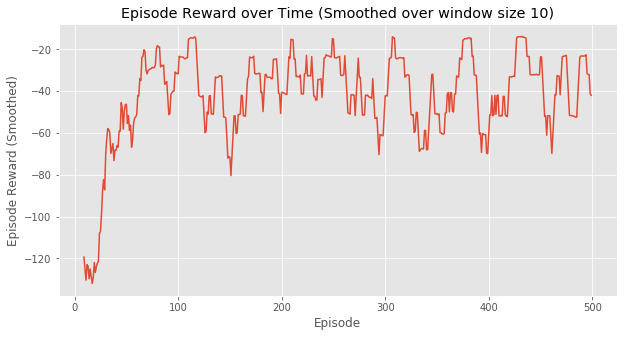

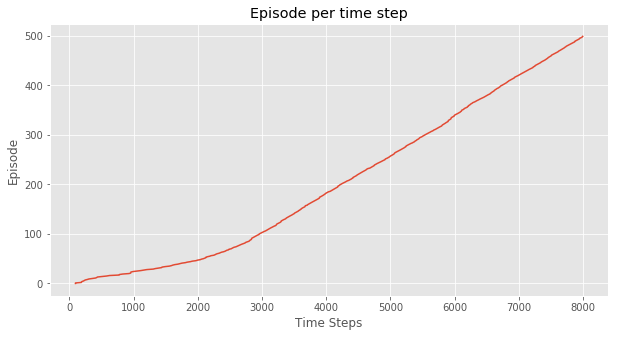

(<matplotlib.figure.Figure at 0x1048e5160>,
 <matplotlib.figure.Figure at 0x109e2ca90>)

In [6]:
plotting.plot_episode_stats(stats)